In [4]:
# Load the feature-selected datasets
import pandas as pd

train = pd.read_csv("train_feature_selected.csv")
test = pd.read_csv("test_feature_selected.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)
print(train.head())

train = pd.read_csv("train_feature_selected.csv")
test = pd.read_csv("test_feature_selected.csv")


Train shape: (918, 37)
Test shape: (355, 37)
       Time Day_of_week Age_band_of_driver Drivers_gender   Educational_level  \
0   7:30:00     Tuesday              31-50           Male  Junior high school   
1  16:20:00   Wednesday              31-50           Male   Elementary school   
2  17:30:00     Tuesday              31-50           Male  Junior high school   
3  20:15:00      Monday              31-50           Male   Elementary school   
4   5:46:00      Friday              18-30           Male   Elementary school   

  Vehicle_driver_relation Driving_experience      Type_of_vehicle  \
0                Employee              1-2yr           Automobile   
1                   Owner              2-5yr      Lorry (41?100Q)   
2                Employee              2-5yr  Public (> 45 seats)   
3                Employee              2-5yr           Automobile   
4                Employee             5-10yr     Pick up upto 10Q   

  Owner_of_vehicle Service_year_of_vehicle  ... Weath

In [2]:
# Separate features and target
target_col = "Accident_severity"   # change if different
X_train = train.drop(columns=[target_col])
y_train = train[target_col]

X_test = test.drop(columns=[target_col], errors="ignore")  # in case test has no target


In [8]:
target_col = "Accident_severity"   # adjust if needed

# Separate target and features
X_train = train.drop(columns=[target_col], errors="ignore")
y_train = train[target_col]

X_test = test.drop(columns=[target_col], errors="ignore")

# Convert all feature columns to numeric (if stored as strings)
X_train = X_train.apply(pd.to_numeric, errors="coerce")
X_test = X_test.apply(pd.to_numeric, errors="coerce")

# Drop any constant/empty columns
X_train = X_train.dropna(axis=1, how="all")
X_test = X_test.dropna(axis=1, how="all")

print("Numeric train features:", X_train.shape[1])
print("Numeric test features:", X_test.shape[1])


Numeric train features: 12
Numeric test features: 12


In [13]:
# Fill NaN with column mean
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())

print("Remaining NaN in train:", X_train.isna().sum().sum())
print("Remaining NaN in test :", X_test.isna().sum().sum())


Remaining NaN in train: 0
Remaining NaN in test : 0


In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [15]:
from sklearn.decomposition import PCA
import numpy as np

# Fit PCA with all components
pca_full = PCA()
pca_full.fit(X_train_scaled)

# Cumulative explained variance
explained_var = np.cumsum(pca_full.explained_variance_ratio_)
print("Cumulative explained variance by components:\n", explained_var)

# Number of components needed for ≥85% variance
n_components = np.argmax(explained_var >= 0.85) + 1
print(f"✅ Number of components for >=85% variance: {n_components}")


Cumulative explained variance by components:
 [0.17604293 0.29174927 0.38727774 0.48112475 0.57342977 0.66472474
 0.75575779 0.84637485 0.93399107 0.99522229 1.         1.        ]
✅ Number of components for >=85% variance: 9


In [16]:
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("Train PCA shape:", X_train_pca.shape)
print("Test PCA shape:", X_test_pca.shape)


Train PCA shape: (918, 9)
Test PCA shape: (355, 9)


In [17]:
# Create DataFrames with PC names
train_pca = pd.DataFrame(X_train_pca, columns=[f"PC{i+1}" for i in range(n_components)])
train_pca[target_col] = y_train.values

test_pca = pd.DataFrame(X_test_pca, columns=[f"PC{i+1}" for i in range(n_components)])
if target_col in test.columns:
    test_pca[target_col] = test[target_col].values

# Save
train_pca.to_csv("train_pca.csv", index=False)
test_pca.to_csv("test_pca.csv", index=False)

print("✅ Saved 'train_pca.csv' and 'test_pca.csv'")


✅ Saved 'train_pca.csv' and 'test_pca.csv'


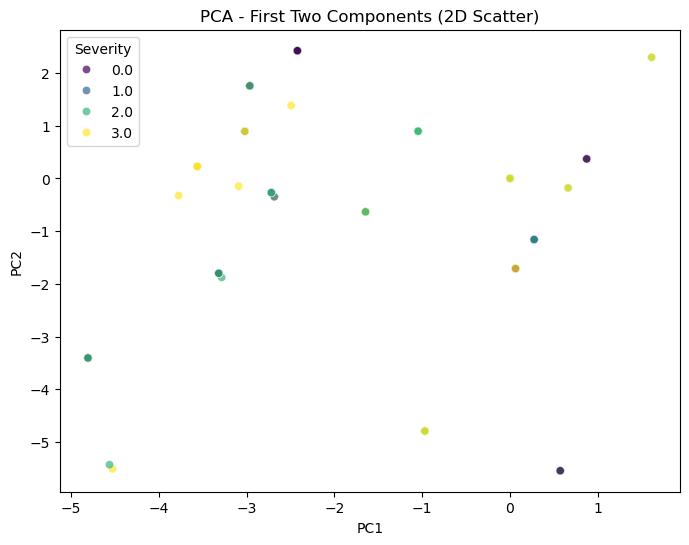

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Force 2D PCA for visualization
pca_2d = PCA(n_components=2)
X_train_pca2d = pca_2d.fit_transform(X_train_scaled)

# Build DataFrame
pca_df = pd.DataFrame(X_train_pca2d, columns=['PC1', 'PC2'])
pca_df[target_col] = y_train.values

# Plot
plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue=target_col,
                palette='viridis', alpha=0.7)
plt.title("PCA - First Two Components (2D Scatter)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Severity")
plt.show()
